# Nature-Inspired Optimization for Local SHAP Explanations

This notebook implements optimization algorithms (GA, PSO, SA) to find minimal feature subsets that preserve both prediction and SHAP explanation fidelity.

## Key Implementation Details

1. **SHAP Values**: Extracted only for the positive class (class 1) and returned as 1D vectors of shape `(n_features,)`
2. **Explainer Reuse**: The same SHAP explainer is reused across all fitness evaluations to avoid reinitialization
3. **Feature Constraint**: At least one feature must be selected in every candidate solution (enforced in all algorithms and fitness function)


In [91]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Import custom modules (they are in the same directory)
# Use importlib to ensure we get the latest version of modules
import importlib
import data_loader
import model
import shap_explaliner
import fitness
import ga_optimizer
import pso_optimizer
import sa_optimizer

# Reload modules to get latest changes
importlib.reload(data_loader)
importlib.reload(model)
importlib.reload(shap_explaliner)
importlib.reload(fitness)
importlib.reload(ga_optimizer)
importlib.reload(pso_optimizer)
importlib.reload(sa_optimizer)

from data_loader import load_data
from model import train_rf
from shap_explaliner import compute_shap
from fitness import fitness_function
from ga_optimizer import genetic_algorithm
from pso_optimizer import binary_pso
from sa_optimizer import simulated_annealing

print("Libraries imported successfully!")
print("Note: Modules reloaded to ensure latest code is used")


Libraries imported successfully!
Note: Modules reloaded to ensure latest code is used


## 1. Dataset Loading & Inspection


In [92]:
# Load dataset using ucimlrepo
X_train, X_test, y_train, y_test, heart_disease = load_data()

# Display dataset metadata
print("="*60)
print("Dataset Metadata:")
print("="*60)
metadata = heart_disease.metadata
print(f"Dataset Name: {metadata.get('name', 'N/A')}")
print(f"Number of Instances: {metadata.get('num_instances', 'N/A')}")
print(f"Number of Features: {metadata.get('num_features', 'N/A')}")
print(f"Feature Types: {metadata.get('feature_types', 'N/A')}")
print(f"Has Missing Values: {metadata.get('has_missing_values', 'N/A')}")

print("\n" + "="*60)
print("Variable Information:")
print("="*60)
if hasattr(heart_disease, 'variables') and heart_disease.variables is not None:
    print(heart_disease.variables)
else:
    print("Variable info not available")

print("\n" + "="*60)
print("Data Summary:")
print("="*60)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nFeature names: {list(X_train.columns)}")
print(f"\nTraining target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")
print(f"\nAll features numeric: {X_train.select_dtypes(exclude=[np.number]).shape[1] == 0}")
print(f"Target is binary: {len(np.unique(y_train)) == 2}")


Missing values before handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

Target distribution: [164 139]
Features shape: (303, 13)
All features numeric: True

Train shape: (212, 13), Test shape: (91, 13)
Dataset Metadata:
Dataset Name: Heart Disease
Number of Instances: 303
Number of Features: 13
Feature Types: ['Categorical', 'Integer', 'Real']
Has Missing Values: yes

Variable Information:
        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8

## 2. Model Training (Black-Box Model)


In [93]:
# Train Random Forest classifier
rf_model, test_accuracy, test_f1 = train_rf(
    X_train, y_train, X_test, y_test,
    n_estimators=100,
    max_depth=5,
    random_state=RANDOM_STATE
)

print(f"\nModel Performance:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Ensure model has reasonable performance
if test_accuracy < 0.7:
    print("\nWarning: Model accuracy is below 0.7. Consider adjusting hyperparameters.")
else:
    print("\nModel performance is acceptable for SHAP explanations.")


Random Forest Test Accuracy: 0.8352
Random Forest Test F1-Score: 0.8148

Model Performance:
Test Accuracy: 0.8352
Test F1-Score: 0.8148

Model performance is acceptable for SHAP explanations.


## 3. Local SHAP Explanation (Baseline)


In [94]:
# Select one instance from test set for local explanation
instance_idx = 0  # Start with first instance
X_instance = X_test.iloc[instance_idx:instance_idx+1].copy()

print(f"Selected instance index: {instance_idx}")
print(f"Instance features:\n{X_instance}")
# Handle y_test as either Series or array
true_label = y_test.iloc[instance_idx] if hasattr(y_test, 'iloc') else y_test[instance_idx]
print(f"\nTrue label: {true_label}")
print(f"Predicted label: {rf_model.predict(X_instance)[0]}")
print(f"Prediction probability (positive class): {rf_model.predict_proba(X_instance)[0, 1]:.4f}")

# Compute full SHAP explanation (baseline)
# Note: compute_shap returns SHAP values for positive class only, as a 1D vector of shape (n_features,)
# The function handles both list and array formats from SHAP and extracts the positive class correctly
full_shap, shap_explainer = compute_shap(rf_model, X_instance)
full_pred = rf_model.predict_proba(X_instance)[0, 1]

print(f"\nFull SHAP values (positive class):")
print(f"Shape: {full_shap.shape} (should be 1D: ({len(X_train.columns)},))")

# If still 2D, manually extract positive class
if len(full_shap.shape) == 2:
    print(f"Warning: SHAP values are 2D with shape {full_shap.shape}, extracting positive class...")
    if full_shap.shape[1] == 2:
        full_shap = full_shap[:, 1]  # Extract positive class column
        print(f"Extracted positive class, new shape: {full_shap.shape}")
    else:
        full_shap = full_shap.flatten()
        print(f"Flattened to shape: {full_shap.shape}")

# Ensure it's 1D
full_shap = np.array(full_shap).flatten()

print(f"Final shape: {full_shap.shape}")
print(f"SHAP values: {full_shap}")
print(f"Sum of SHAP values: {np.sum(full_shap):.4f}")
print(f"Full prediction probability: {full_pred:.4f}")

# Verify SHAP values are 1D and have correct number of features
assert len(full_shap.shape) == 1, f"SHAP values should be 1D, but got shape {full_shap.shape}"
assert full_shap.shape[0] == len(X_train.columns), f"SHAP values should have {len(X_train.columns)} features, but got {full_shap.shape[0]}"

# Store baseline values
# shap_explainer will be reused in fitness function to avoid reinitialization
BASELINE_SHAP = full_shap.copy()
BASELINE_PRED = full_pred
print(f"\n✓ SHAP explainer created and will be reused for all fitness evaluations")
print(f"✓ Baseline SHAP values stored as 1D vector with {len(BASELINE_SHAP)} features")


Selected instance index: 0
Instance features:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
76   60    1   4       125   258    0        2      141      1      2.8   

    slope   ca  thal  
76      2  1.0   7.0  

True label: 1
Predicted label: 1
Prediction probability (positive class): 0.9824

Full SHAP values (positive class):
Shape: (13,) (should be 1D: (13,))
Final shape: (13,)
SHAP values: [0.03023641 0.01986405 0.10187099 0.00315358 0.00755633 0.00150685
 0.00670212 0.03907349 0.03242785 0.08211599 0.01747321 0.07391999
 0.10760594]
Sum of SHAP values: 0.5235
Full prediction probability: 0.9824

✓ SHAP explainer created and will be reused for all fitness evaluations
✓ Baseline SHAP values stored as 1D vector with 13 features


## 4. Feature Masking Strategy


In [95]:
# Compute baseline values (mean from training data)
baseline_values = X_train.mean(axis=0)

print("Feature Masking Strategy:")
print("="*60)
print("When a feature is NOT selected:")
print("- Replace its value with the mean (baseline) from training data")
print("- This ensures consistent masking across prediction and SHAP computation")
print("\nBaseline values (mean from training data):")
print(baseline_values)

# Test masking with a simple example
test_mask = np.random.randint(0, 2, len(X_train.columns))
test_mask[0] = 1  # Ensure at least one feature selected
X_masked_test = X_instance.copy()
# Mask unselected features by iterating over columns (same approach as fitness function)
unselected_cols = X_instance.columns[~test_mask.astype(bool)]
for col in unselected_cols:
    baseline_val = float(baseline_values[col])
    # Convert column to float if needed to avoid dtype incompatibility
    if X_masked_test[col].dtype != float:
        X_masked_test[col] = X_masked_test[col].astype(float)
    X_masked_test.loc[:, col] = baseline_val

print(f"\nExample: Masking with {np.sum(test_mask)} features selected")
print(f"Original instance prediction: {rf_model.predict_proba(X_instance)[0, 1]:.4f}")
print(f"Masked instance prediction: {rf_model.predict_proba(X_masked_test)[0, 1]:.4f}")


Feature Masking Strategy:


When a feature is NOT selected:
- Replace its value with the mean (baseline) from training data
- This ensures consistent masking across prediction and SHAP computation

Baseline values (mean from training data):
age          54.613208
sex           0.688679
cp            3.183962
trestbps    130.023585
chol        249.702830
fbs           0.122642
restecg       1.014151
thalach     149.693396
exang         0.320755
oldpeak       0.997170
slope         1.584906
ca            0.632075
thal          4.673275
dtype: float64

Example: Masking with 4 features selected
Original instance prediction: 0.9824
Masked instance prediction: 0.7179


## 5. Fitness Function Definition


In [96]:
# Define fitness function weights
ALPHA = 1.0  # Weight for prediction fidelity
BETA = 1.0   # Weight for SHAP fidelity
GAMMA = 0.1  # Weight for sparsity (lower = encourage more sparsity)

print("Fitness Function Components:")
print("="*60)
print(f"1. Prediction Fidelity (weight={ALPHA}):")
print("   - Absolute difference between full and masked prediction")
print(f"2. SHAP Fidelity (weight={BETA}):")
print("   - Normalized L2 norm of SHAP value differences")
print(f"3. Sparsity Penalty (weight={GAMMA}):")
print("   - Ratio of selected features to total features")
print("\nLower fitness value = better solution")

# Create a wrapper function for optimization algorithms
# Note: The explainer is reused here to avoid reinitializing it for each fitness evaluation
def fitness_wrapper(x):
    """
    Wrapper function for fitness that algorithms can call.
    
    Important:
    - Reuses the same SHAP explainer (shap_explainer) for efficiency
    - Ensures at least one feature is selected (enforced in fitness_function)
    - SHAP values are computed only for the positive class as 1D vectors
    """
    return fitness_function(
        x, rf_model, X_instance, X_train, 
        BASELINE_SHAP, BASELINE_PRED, 
        explainer=shap_explainer,  # Reuse explainer - do not reinitialize
        alpha=ALPHA, beta=BETA, gamma=GAMMA
    )

# Test fitness function with all features selected
all_features = np.ones(len(X_train.columns))
fitness_all = fitness_wrapper(all_features)
print(f"\nFitness with all features selected: {fitness_all:.6f}")

# Test fitness function with half features selected
half_features = np.random.randint(0, 2, len(X_train.columns))
half_features[np.random.randint(0, len(X_train.columns))] = 1  # Ensure at least one
fitness_half = fitness_wrapper(half_features)
print(f"Fitness with {np.sum(half_features)} features selected: {fitness_half:.6f}")


Fitness Function Components:
1. Prediction Fidelity (weight=1.0):
   - Absolute difference between full and masked prediction
2. SHAP Fidelity (weight=1.0):
   - Normalized L2 norm of SHAP value differences
3. Sparsity Penalty (weight=0.1):
   - Ratio of selected features to total features

Lower fitness value = better solution

Fitness with all features selected: 0.100000
Fitness with 9 features selected: 1.325034


## 6. Optimization Problem Definition


In [97]:
n_features = len(X_train.columns)
print("Optimization Problem:")
print("="*60)
print(f"Search space: Binary vectors of length {n_features}")
print(f"Total possible solutions: 2^{n_features} = {2**n_features}")
print(f"\nConstraint: At least one feature must be selected")
print("  - Enforced in all optimization algorithms (GA, PSO, SA)")
print("  - Enforced in fitness function (returns high penalty if violated)")
print(f"\nObjective: Minimize fitness function")
print(f"\nSame encoding used by:")
print("- Genetic Algorithm (GA)")
print("- Particle Swarm Optimization (PSO)")
print("- Simulated Annealing (SA)")
print(f"\nImplementation details:")
print("- SHAP values extracted only for positive class (1D vector)")
print("- Same SHAP explainer reused across all fitness evaluations")
print("- At least one feature constraint enforced at every step")


Optimization Problem:
Search space: Binary vectors of length 13
Total possible solutions: 2^13 = 8192

Constraint: At least one feature must be selected
  - Enforced in all optimization algorithms (GA, PSO, SA)
  - Enforced in fitness function (returns high penalty if violated)

Objective: Minimize fitness function

Same encoding used by:
- Genetic Algorithm (GA)
- Particle Swarm Optimization (PSO)
- Simulated Annealing (SA)

Implementation details:
- SHAP values extracted only for positive class (1D vector)
- Same SHAP explainer reused across all fitness evaluations
- At least one feature constraint enforced at every step


## 7. Genetic Algorithm (GA) Optimization


Running Genetic Algorithm...



GA Results:
Best fitness: 0.069231
Number of selected features: 9
Selected feature indices: [0, 2, 3, 4, 6, 7, 8, 9, 12]
Selected feature names: ['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'thal']


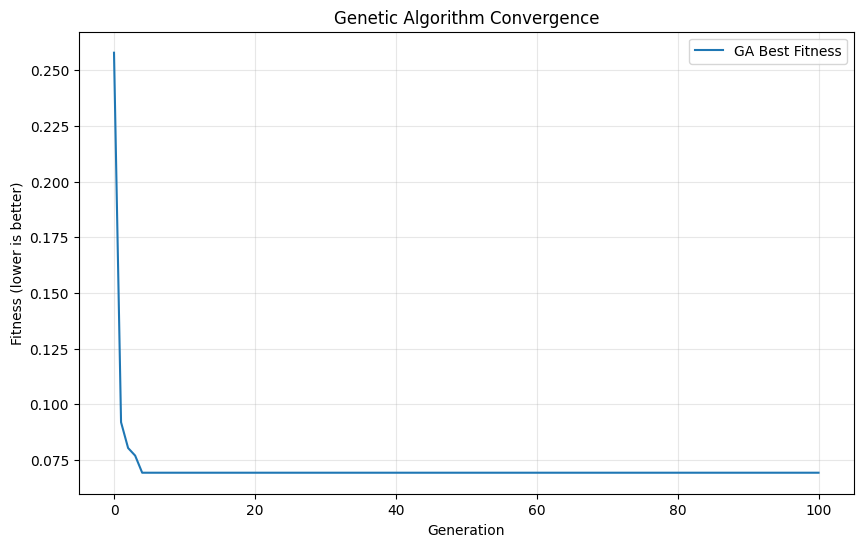

In [98]:
# Run Genetic Algorithm
print("Running Genetic Algorithm...")
print("="*60)

ga_solution, ga_fitness, ga_history = genetic_algorithm(
    fitness_func=fitness_wrapper,
    n_features=n_features,
    n_population=50,
    n_generations=100,
    crossover_rate=0.8,
    mutation_rate=0.1,
    random_state=RANDOM_STATE
)

print(f"\nGA Results:")
print(f"Best fitness: {ga_fitness:.6f}")
print(f"Number of selected features: {np.sum(ga_solution)}")
print(f"Selected feature indices: {np.where(ga_solution == 1)[0].tolist()}")
print(f"Selected feature names: {X_train.columns[ga_solution == 1].tolist()}")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(ga_history, label='GA Best Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness (lower is better)')
plt.title('Genetic Algorithm Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 8. Particle Swarm Optimization (PSO)


Running Particle Swarm Optimization...

PSO Results:
Best fitness: 0.069231
Number of selected features: 9
Selected feature indices: [0, 2, 3, 4, 6, 7, 8, 9, 12]
Selected feature names: ['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'thal']


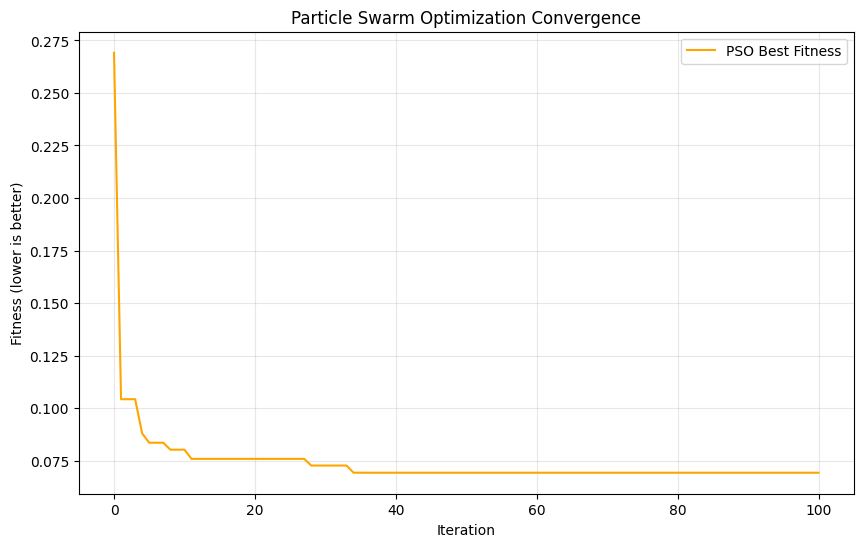

In [99]:
# Run Binary PSO
print("Running Particle Swarm Optimization...")
print("="*60)

pso_solution, pso_fitness, pso_history = binary_pso(
    fitness_func=fitness_wrapper,
    n_features=n_features,
    n_particles=30,
    n_iterations=100,
    w=0.7,
    c1=1.5,
    c2=1.5,
    random_state=RANDOM_STATE
)

print(f"\nPSO Results:")
print(f"Best fitness: {pso_fitness:.6f}")
print(f"Number of selected features: {np.sum(pso_solution)}")
print(f"Selected feature indices: {np.where(pso_solution == 1)[0].tolist()}")
print(f"Selected feature names: {X_train.columns[pso_solution == 1].tolist()}")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(pso_history, label='PSO Best Fitness', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Fitness (lower is better)')
plt.title('Particle Swarm Optimization Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 9. Simulated Annealing (SA) Optimization


Running Simulated Annealing...

SA Results:
Best fitness: 0.069231
Number of selected features: 9
Selected feature indices: [0, 2, 3, 4, 6, 7, 8, 9, 12]
Selected feature names: ['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'thal']


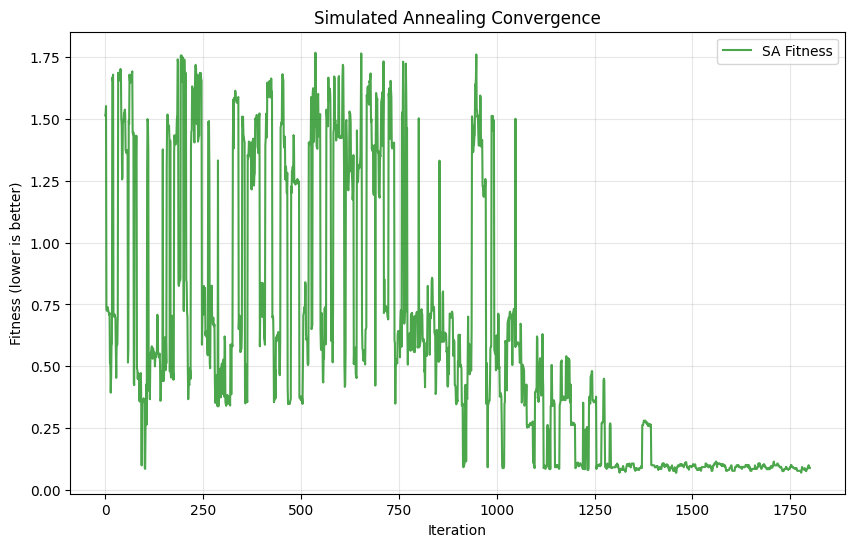

In [100]:
# Run Simulated Annealing
print("Running Simulated Annealing...")
print("="*60)

sa_solution, sa_fitness, sa_history = simulated_annealing(
    fitness_func=fitness_wrapper,
    n_features=n_features,
    initial_temp=100.0,
    final_temp=0.01,
    cooling_rate=0.95,
    iterations_per_temp=10,
    random_state=RANDOM_STATE
)

print(f"\nSA Results:")
print(f"Best fitness: {sa_fitness:.6f}")
print(f"Number of selected features: {np.sum(sa_solution)}")
print(f"Selected feature indices: {np.where(sa_solution == 1)[0].tolist()}")
print(f"Selected feature names: {X_train.columns[sa_solution == 1].tolist()}")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(sa_history, label='SA Fitness', color='green', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Fitness (lower is better)')
plt.title('Simulated Annealing Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 10. Result Comparison


Algorithm Comparison

Results Summary:
  Algorithm   Fitness  Num Features
0        GA  0.069231             9
1       PSO  0.069231             9
2        SA  0.069231             9


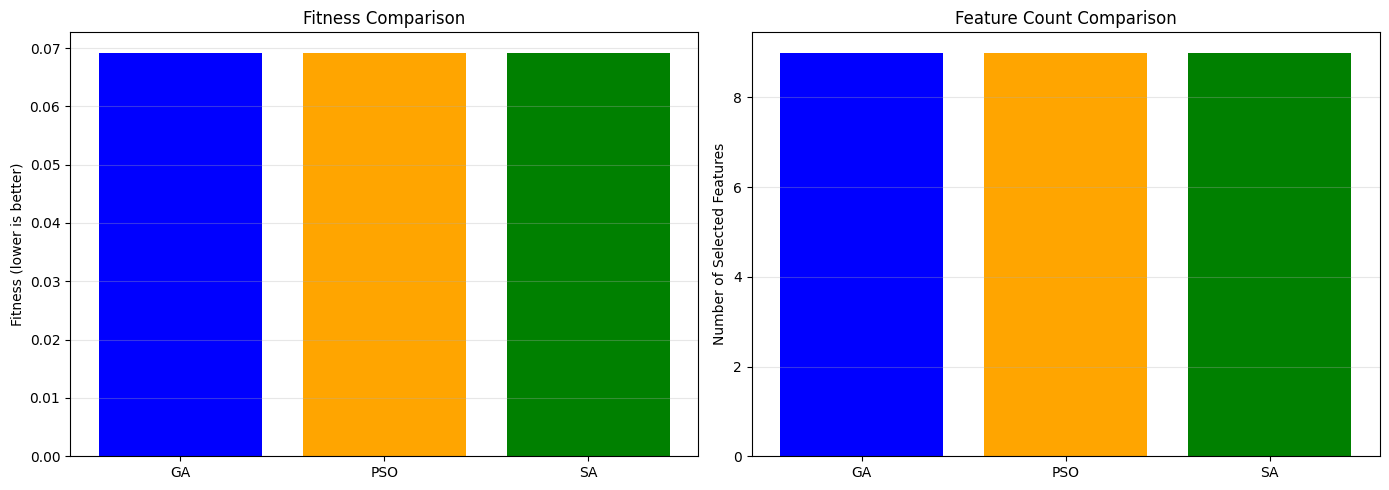

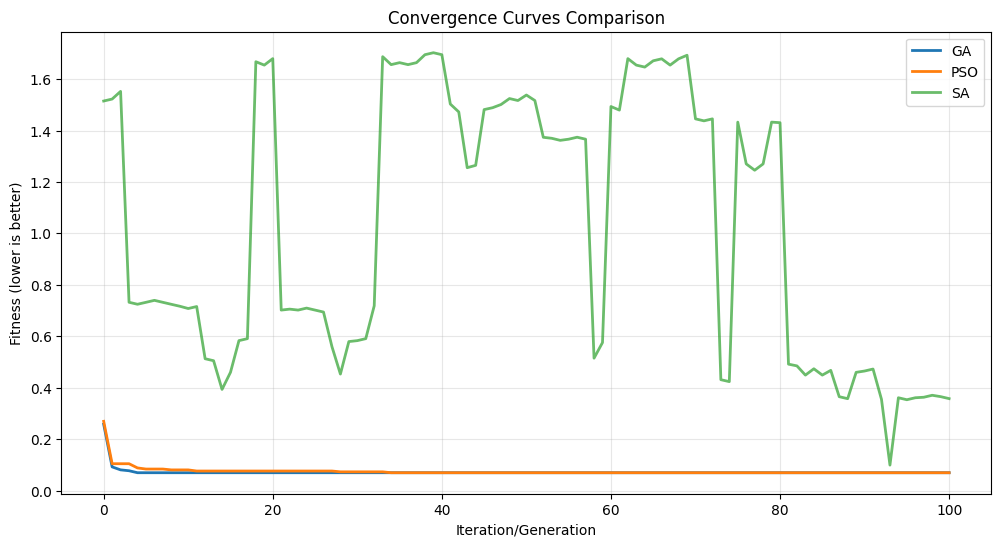

In [101]:
# Compare all algorithms
print("="*60)
print("Algorithm Comparison")
print("="*60)

results = {
    'Algorithm': ['GA', 'PSO', 'SA'],
    'Fitness': [ga_fitness, pso_fitness, sa_fitness],
    'Num Features': [np.sum(ga_solution), np.sum(pso_solution), np.sum(sa_solution)]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fitness comparison
axes[0].bar(results_df['Algorithm'], results_df['Fitness'], color=['blue', 'orange', 'green'])
axes[0].set_ylabel('Fitness (lower is better)')
axes[0].set_title('Fitness Comparison')
axes[0].grid(True, alpha=0.3, axis='y')

# Number of features comparison
axes[1].bar(results_df['Algorithm'], results_df['Num Features'], color=['blue', 'orange', 'green'])
axes[1].set_ylabel('Number of Selected Features')
axes[1].set_title('Feature Count Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Convergence curves comparison
plt.figure(figsize=(12, 6))
plt.plot(ga_history, label='GA', linewidth=2)
plt.plot(pso_history, label='PSO', linewidth=2)
plt.plot(sa_history[:len(ga_history)], label='SA', linewidth=2, alpha=0.7)
plt.xlabel('Iteration/Generation')
plt.ylabel('Fitness (lower is better)')
plt.title('Convergence Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 11. Detailed Analysis of Best Solution


Best algorithm: GA

Best Solution Analysis:
Algorithm: GA
Fitness: 0.069231
Number of features: 9

Selected features:
  1. age
  2. cp
  3. trestbps
  4. chol
  5. restecg
  6. thalach
  7. exang
  8. oldpeak
  9. thal

Prediction Fidelity:
  Full prediction: 0.9824
  Masked prediction: 0.9824
  Error: 0.0000

SHAP Fidelity:
  Normalized L2 error: 0.000000


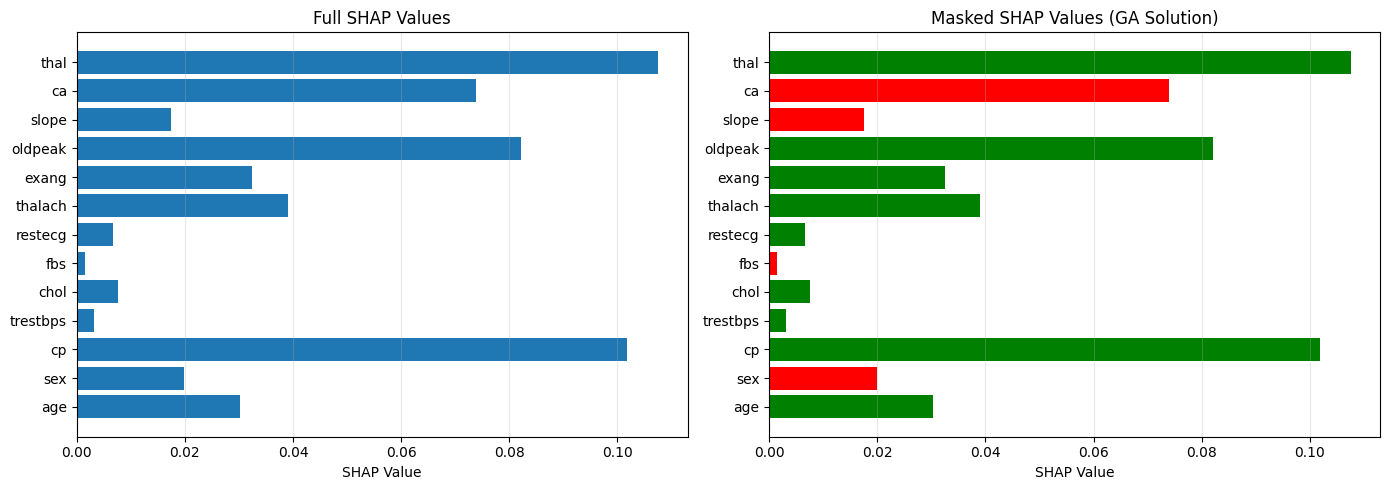

In [ ]:
# Find best solution overall
best_algo = results_df.loc[results_df['Fitness'].idxmin(), 'Algorithm']
print(f"Best algorithm: {best_algo}")

if best_algo == 'GA':
    best_solution = ga_solution
    best_fitness = ga_fitness
elif best_algo == 'PSO':
    best_solution = pso_solution
    best_fitness = pso_fitness
else:
    best_solution = sa_solution
    best_fitness = sa_fitness

# Evaluate best solution
print(f"\nBest Solution Analysis:")
print("="*60)
print(f"Algorithm: {best_algo}")
print(f"Fitness: {best_fitness:.6f}")
print(f"Number of features: {np.sum(best_solution)}")
print(f"\nSelected features:")
selected_features = X_train.columns[best_solution == 1]
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

# Compare predictions
X_masked_best = X_instance.copy()
baseline = X_train.mean(axis=0)
# Mask unselected features by iterating over columns (same approach as fitness function)
unselected_cols = X_instance.columns[~best_solution.astype(bool)]
for col in unselected_cols:
    baseline_val = float(baseline[col])
    # Convert column to float if needed to avoid dtype incompatibility
    if X_masked_best[col].dtype != float:
        X_masked_best[col] = X_masked_best[col].astype(float)
    X_masked_best.loc[:, col] = baseline_val

pred_full = rf_model.predict_proba(X_instance)[0, 1]
pred_masked = rf_model.predict_proba(X_masked_best)[0, 1]
pred_error = np.abs(pred_full - pred_masked)

print(f"\nPrediction Fidelity:")
print(f"  Full prediction: {pred_full:.4f}")
print(f"  Masked prediction: {pred_masked:.4f}")
print(f"  Error: {pred_error:.4f}")

# Compare SHAP values
# Reuse the same explainer and extract positive class as 1D vector
shap_masked, _ = compute_shap(rf_model, X_masked_best, explainer=shap_explainer)
# Ensure it's 1D and matches BASELINE_SHAP shape
shap_masked = np.array(shap_masked).flatten()
assert len(shap_masked.shape) == 1, f"Masked SHAP should be 1D, but got shape {shap_masked.shape}"
assert shap_masked.shape[0] == BASELINE_SHAP.shape[0], f"Shape mismatch: BASELINE_SHAP={BASELINE_SHAP.shape[0]}, masked={shap_masked.shape[0]}"

shap_error = np.linalg.norm(BASELINE_SHAP - shap_masked) / (np.linalg.norm(BASELINE_SHAP) + 1e-8)

print(f"\nSHAP Fidelity:")
print(f"  Normalized L2 error: {shap_error:.6f}")

# Visualize SHAP values comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full SHAP - ensure it's 1D
shap_values_full = np.array(BASELINE_SHAP).flatten()
# Handle case where BASELINE_SHAP might be 2D (if it's a list or has multiple classes)
if len(shap_values_full.shape) > 1:
    # If it's 2D with shape (n_features, n_classes), take the positive class (index 1)
    if shap_values_full.shape[1] == 2:
        shap_values_full = shap_values_full[:, 1]
    else:
        shap_values_full = shap_values_full.flatten()

# Ensure we have the correct number of features
n_features_shap = len(shap_values_full)
n_features_train = len(X_train.columns)

# Use the correct column names - match the length of SHAP values
if n_features_shap == n_features_train:
    feature_labels = list(X_train.columns)
else:
    # If there's a mismatch, use indices or adjust
    print(f"Warning: SHAP values have {n_features_shap} features, but X_train has {n_features_train} columns")
    feature_labels = [f'Feature {i}' for i in range(n_features_shap)]
    # Try to use X_train columns if possible
    if n_features_shap > n_features_train:
        # Pad with generic names
        feature_labels = list(X_train.columns) + [f'Feature {i}' for i in range(n_features_train, n_features_shap)]
    else:
        # Truncate
        feature_labels = list(X_train.columns[:n_features_shap])

axes[0].barh(range(len(shap_values_full)), shap_values_full)
axes[0].set_yticks(range(len(shap_values_full)))
axes[0].set_yticklabels(feature_labels)
axes[0].set_xlabel('SHAP Value')
axes[0].set_title('Full SHAP Values')
axes[0].grid(True, alpha=0.3, axis='x')

# Masked SHAP (only selected features) - ensure it's 1D
shap_values_masked = np.array(shap_masked).flatten()
if len(shap_values_masked.shape) > 1:
    if shap_values_masked.shape[1] == 2:
        shap_values_masked = shap_values_masked[:, 1]
    else:
        shap_values_masked = shap_values_masked.flatten()

# Ensure masked SHAP has same length as full SHAP
if len(shap_values_masked) != len(shap_values_full):
    print(f"Warning: Masked SHAP has {len(shap_values_masked)} values, but full SHAP has {len(shap_values_full)}")
    # Pad or truncate to match
    if len(shap_values_masked) < len(shap_values_full):
        shap_values_masked = np.pad(shap_values_masked, (0, len(shap_values_full) - len(shap_values_masked)), 'constant')
    else:
        shap_values_masked = shap_values_masked[:len(shap_values_full)]

axes[1].barh(range(len(shap_values_masked)), shap_values_masked, 
             color=['green' if best_solution[i] else 'red' for i in range(min(len(best_solution), len(shap_values_masked)))])
axes[1].set_yticks(range(len(shap_values_masked)))
axes[1].set_yticklabels(feature_labels)
axes[1].set_xlabel('SHAP Value')
axes[1].set_title(f'Masked SHAP Values ({best_algo} Solution)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 12. Multiple Runs for Statistical Analysis


In [103]:
# Run each algorithm multiple times for statistical analysis
N_RUNS = 20
print(f"Running each algorithm {N_RUNS} times for statistical analysis...")
print("="*60)

ga_results = []
pso_results = []
sa_results = []

ga_features = []
pso_features = []
sa_features = []

for run in range(N_RUNS):
    if (run + 1) % 5 == 0:
        print(f"Run {run + 1}/{N_RUNS}...")
    
    # GA
    ga_sol, ga_fit, _ = genetic_algorithm(
        fitness_func=fitness_wrapper,
        n_features=n_features,
        n_population=50,
        n_generations=100,
        crossover_rate=0.8,
        mutation_rate=0.1,
        random_state=RANDOM_STATE + run
    )
    ga_results.append(ga_fit)
    ga_features.append(np.sum(ga_sol))
    
    # PSO
    pso_sol, pso_fit, _ = binary_pso(
        fitness_func=fitness_wrapper,
        n_features=n_features,
        n_particles=30,
        n_iterations=100,
        w=0.7,
        c1=1.5,
        c2=1.5,
        random_state=RANDOM_STATE + run
    )
    pso_results.append(pso_fit)
    pso_features.append(np.sum(pso_sol))
    
    # SA
    sa_sol, sa_fit, _ = simulated_annealing(
        fitness_func=fitness_wrapper,
        n_features=n_features,
        initial_temp=100.0,
        final_temp=0.01,
        cooling_rate=0.95,
        iterations_per_temp=10,
        random_state=RANDOM_STATE + run
    )
    sa_results.append(sa_fit)
    sa_features.append(np.sum(sa_sol))

print("\nStatistical Summary:")
print("="*60)

stats_data = {
    'Algorithm': ['GA'] * N_RUNS + ['PSO'] * N_RUNS + ['SA'] * N_RUNS,
    'Fitness': ga_results + pso_results + sa_results,
    'NumFeatures': ga_features + pso_features + sa_features
}
stats_df = pd.DataFrame(stats_data)

summary = stats_df.groupby('Algorithm').agg({
    'Fitness': ['mean', 'std', 'min', 'max'],
    'NumFeatures': ['mean', 'std', 'min', 'max']
}).round(6)

print(summary)

# Box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stats_df.boxplot(column='Fitness', by='Algorithm', ax=axes[0])
axes[0].set_title('Fitness Distribution')
axes[0].set_ylabel('Fitness (lower is better)')
axes[0].set_xlabel('')
axes[0].grid(True, alpha=0.3)

stats_df.boxplot(column='NumFeatures', by='Algorithm', ax=axes[1])
axes[1].set_title('Number of Features Distribution')
axes[1].set_ylabel('Number of Features')
axes[1].set_xlabel('')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
import os
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)
results_file = os.path.join(results_dir, 'results_optimization.csv')
stats_df.to_csv(results_file, index=False)
print(f"\nResults saved to: {results_file}")


Running each algorithm 20 times for statistical analysis...
Run 5/20...


KeyboardInterrupt: 